In [2]:
pip install torch

  Using cached torch-2.3.1-cp312-cp312-win_amd64.whl.metadata (26 kB)
  Using cached filelock-3.15.4-py3-none-any.whl.metadata (2.9 kB)
  Using cached jinja2-3.1.4-py3-none-any.whl.metadata (2.6 kB)
  Using cached mkl-2021.4.0-py2.py3-none-win_amd64.whl.metadata (1.4 kB)
  Using cached intel_openmp-2021.4.0-py2.py3-none-win_amd64.whl.metadata (1.2 kB)
  Using cached MarkupSafe-2.1.5-cp312-cp312-win_amd64.whl.metadata (3.1 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
Using cached torch-2.3.1-cp312-cp312-win_amd64.whl (159.7 MB)
Using cached mkl-2021.4.0-py2.py3-none-win_amd64.whl (228.5 MB)
Using cached intel_openmp-2021.4.0-py2.py3-none-win_amd64.whl (3.5 MB)
   ---------------------------------------- 0.0/286.9 kB ? eta -:--:--
   ---------------------------------------- 286.9/286.9 kB 5.9 MB/s eta 0:00:00
Using cached filelock-3.15.4-py3-none-any.whl (16 kB)
   ---------------------------------------- 0.0/177.6 kB ? eta -:--:--
   -------------------------------

In [3]:
pip install torch torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric 

  Using cached torch_scatter-2.1.2.tar.gz (108 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/210.0 kB ? eta -:--:--
     -------------------------------------- 210.0/210.0 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/54.5 kB ? eta -:--:--
     ---------------------------------------- 54.5/54.5 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/64.2 kB ? eta -:--:--
     ---------------------------------------- 64.2/64.2 kB 3.6 MB/s eta 0:00:00
  Using cached attrs-23.2.0-py3-none-any.whl.metadata (9.5 kB)
  Using cached frozen

In [5]:
pip install scikit-learn matplotlib pandas pyarrow networkx matplotlib  


Note: you may need to restart the kernel to use updated packages.



# 1. OVERVIEW 
## Graph Construction:

Nodes: represent customers, financial products

Edges: represent relationships or interactions between nodes, such as purchase transactions, 

Node Features: Customer demographics, purchase history, preferences, etc.

Edge Features: Transaction amounts, frequency of interactions, etc.

In previous noteboos of this repo (STEP 1), the graph was persisted in graphml format 

## Feature Engineering:

Utilize both node features and edge features to enrich the graph representation.
Apply normalization and encoding techniques to prepare the data for GNN processing.


## GNN Model Training:

Train a GNN to learn embeddings for nodes that capture both the node features and the graph structure.
Use these embeddings for clustering customers into segments.

## Clustering:

Apply clustering algorithms  on the learned node embeddings to identify distinct market segments.

# 2.  Load the graph

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.read_graphml("graph.graphml")

# 3. Feature Enginnering

As I allready have precomputed embeddings from Node2Vec, I will include these embeddings as additional features in my  GNN model. This approach leverages the structural information captured by Node2Vec and combines it with the GNN's ability to learn from node features and graph topology.

x (Node Features):

x is a matrix where each row corresponds to the feature vector of a node in the graph.
The shape of x is [num_nodes, num_node_features].
edge_index (Edge Index):

edge_index is a tensor that represents the edges of the graph.
It is a 2D tensor of shape [2, num_edges], where each column represents an edge. The first row contains the source nodes, and the second row contains the target nodes.
edge_attr (Edge Features):

edge_attr is an optional tensor that contains the features of the edges.
The shape of edge_attr is [num_edges, num_edge_features].

In [2]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from torch_geometric.data import Data
import numpy as np
import torch
from torch_geometric.loader import NeighborLoader

from gensim.models import KeyedVectors


# Load embeddings from file c reated by node2vec
embeddings = KeyedVectors.load("node2vec_embeddings.kv")


# Extract node IDs and features
node_ids = []
node_types = []

for node in G.nodes(data=True):
    node_ids.append(str(node[0]))  
    node_types.append(node[1]['Node_Type'])

node2vec_embeddings = np.array([embeddings[node] for node in node_ids])

# One-hot encode the categorical node features
encoder = OneHotEncoder(sparse_output=False)
node_types_encoded = encoder.fit_transform(np.array(node_types).reshape(-1, 1))

# Create tensor node_features with node2vec embeddings and one-hot encoded node types
node_features = np.hstack([node2vec_embeddings, node_types_encoded])
node_features = torch.tensor(node_features, dtype=torch.float)
node_features

# Step 3: Create edge index and edge features
# Extract node IDs and create a mapping to integer indices
node_ids = list(G.nodes())
node_id_map = {node_id: i for i, node_id in enumerate(node_ids)}

edge_index = []
edge_features = []

for edge in G.edges(data=True):
    source, target = edge[0], edge[1]
    edge_index.append([node_id_map[source], node_id_map[target]])
    edge_features.append([edge[2]['Frequency'], edge[2]['Total_Amount'], edge[2]['Average_Amount']])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Normalize edge features before creating tensor because they have different scales
edge_features = np.array(edge_features)
scaler = MinMaxScaler()
edge_features_normalized = scaler.fit_transform(edge_features)

# Edge weights are a combination of frequency and total amount to reflect the streght of the connections.
frequency_weight = 0.5
total_amount_weight = 0.5
edge_weights = (frequency_weight * edge_features_normalized[:, 0] +
                total_amount_weight * edge_features_normalized[:, 1])
edge_features_normalized = torch.tensor(edge_features_normalized, dtype=torch.float)

# Ensure there are no NaN values in edge weights
edge_weights = np.nan_to_num(edge_weights)
# Convert to tensor
edge_weights = torch.tensor(edge_weights, dtype=torch.float)

# Check for NaNs in node features
if torch.isnan(node_features).any():
    print("NaN values found in node features")
if torch.isnan(edge_weights).any():
    print("NaN values found in edge weights")
# Data object with node features, edge index and edge features
data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_features_normalized, edge_weight=edge_weights)
#It is not necessary to normalize the node features as  the embeddings are already normalized. =torch.float)  # Apply normalization back

# Check for NaNs in the Data object
if torch.isnan(data.x).any():
    print("NaNs found in data.x")
if torch.isnan(data.edge_attr).any():
    print("NaNs found in data.edge_attr")
if torch.isnan(data.edge_weight).any():
    print("NaNs found in data.edge_weight")

data
edge_weights

tensor([0.0123, 0.0032, 0.0027,  ..., 0.0006, 0.0040, 0.0022])

# 4. Split data in Training and Test to evaluate the performance of GNN

In [3]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split
num_nodes = data.num_nodes
train_size = int(0.8 * num_nodes)
test_size = num_nodes - train_size
train_indices, test_indices = train_test_split(range(num_nodes), test_size=test_size, random_state=42)

data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.train_mask[train_indices] = True

data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask[test_indices] = True


# 4. GNN Architecture

## 4.1 Define Contrastive Loss Function



In [4]:
import torch
import torch.nn.functional as F
import random



# Contrastive Loss Function
def contrastive_loss(embeddings, pos_pairs, neg_pairs, margin=1.0):
    pos_loss = 0
    for (i, j) in pos_pairs:
        pos_loss += torch.norm(embeddings[i] - embeddings[j], p=2)
    pos_loss /= len(pos_pairs)

    neg_loss = 0
    for (i, j) in neg_pairs:
        neg_loss += max(0, margin - torch.norm(embeddings[i] - embeddings[j], p=2))
    neg_loss /= len(neg_pairs)

    return pos_loss + neg_loss

import random

def generate_pairs(data, num_neg_samples=1):
    pos_pairs = []
    neg_pairs = []

    # Positive pairs from edges
    for i, j in data.edge_index.t().tolist():
        pos_pairs.append((i, j))

    # Negative pairs
    nodes = list(range(data.num_nodes))
    for _ in range(num_neg_samples * len(pos_pairs)):
        i, j = random.sample(nodes, 2)
        if not data.edge_index[:, (data.edge_index[0] == i) & (data.edge_index[1] == j)].size(1):
            neg_pairs.append((i, j))

    return pos_pairs, neg_pairs

# Generate pairs
pos_pairs, neg_pairs = generate_pairs(data)

def undersample_pairs(pos_pairs, neg_pairs):
    min_len = min(len(pos_pairs), len(neg_pairs))
    pos_pairs = random.sample(pos_pairs, min_len)
    neg_pairs = random.sample(neg_pairs, min_len)
    return pos_pairs, neg_pairs


# Undersample to balance pairs
balanced_pos_pairs, balanced_neg_pairs = undersample_pairs(pos_pairs, neg_pairs)

## 4.2 Regularization using Early Stopping 

In [5]:
class EarlyStopping:
    ## Early stopping to stop the training when the loss does not improve after
    ## a certain number of epochs.
    ## The number of epochs is specified by 'patience' parameter
    ## and the threshold by 'min_delta' parameter.
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = np.inf
        self.counter = 0
 
    def __call__(self, loss):
        if loss < self.best_loss - self.min_delta:
            self.best_loss = loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
            return False


## 4.3 GNN Train

GCN(
  (conv1): GCNConv(4, 32)
  (conv2): GCNConv(32, 16)
)
Epoch 0, Train Loss: 16.8366, Test Loss: 13.6090
Epoch 1, Train Loss: 13.6090, Test Loss: 10.9552
Epoch 2, Train Loss: 10.9552, Test Loss: 8.8124
Epoch 3, Train Loss: 8.8124, Test Loss: 7.0771
Epoch 4, Train Loss: 7.0771, Test Loss: 5.6577
Epoch 5, Train Loss: 5.6577, Test Loss: 4.5414
Epoch 6, Train Loss: 4.5414, Test Loss: 3.7338
Epoch 7, Train Loss: 3.7338, Test Loss: 3.1508
Epoch 8, Train Loss: 3.1508, Test Loss: 2.7425
Epoch 9, Train Loss: 2.7425, Test Loss: 2.5309
Epoch 10, Train Loss: 2.5309, Test Loss: 2.4286
Epoch 11, Train Loss: 2.4286, Test Loss: 2.3356
Epoch 12, Train Loss: 2.3356, Test Loss: 2.3024
Epoch 13, Train Loss: 2.3024, Test Loss: 2.2623
Epoch 14, Train Loss: 2.2623, Test Loss: 2.1527
Epoch 15, Train Loss: 2.1527, Test Loss: 2.0033
Epoch 16, Train Loss: 2.0033, Test Loss: 1.8558
Epoch 17, Train Loss: 1.8558, Test Loss: 1.7434
Epoch 18, Train Loss: 1.7434, Test Loss: 1.6508
Epoch 19, Train Loss: 1.6508, Tes

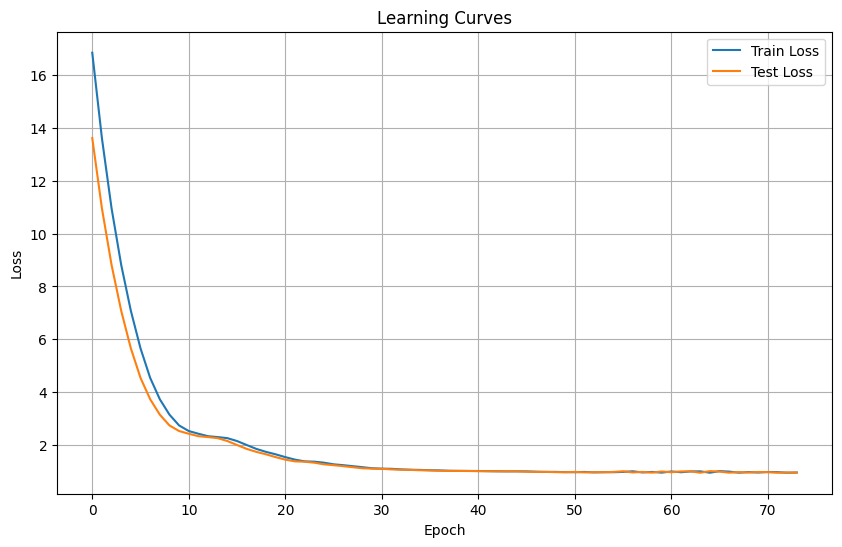

In [9]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import matplotlib.ticker as ticker


class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight
        x = self.conv1(x, edge_index, edge_weight=edge_weight)
        x = F.leaky_relu(x)
        x = self.conv2(x, edge_index, edge_weight=edge_weight)
        return x
in_channels = data.num_node_features
hidden_channels = 32  # Intermediate layer size
out_channels = 16  # Embedding size

model = GCN(in_channels, hidden_channels, out_channels)
# Use Adam optimizer with learning rate of 0.01 and weight decay of 5e-4
# Adam optimizer is used to optimize the model parameters
# Weight decay is used to prevent overfitting why?
# The optimizer is used to update the model parameters during training
# The learning rate is the step size used by the optimizer to update the model parameters
# The weight decay is a regularization term that penalizes large weights to prevent overfitting

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
print(model)


def train(data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = contrastive_loss(out, balanced_pos_pairs, balanced_neg_pairs)   
    loss.backward()
    optimizer.step()
    return loss.item()

def test(data):
    model.eval()
    with torch.no_grad():
        out = model(data)
        loss = contrastive_loss(out, balanced_pos_pairs, balanced_neg_pairs)
    return loss.item()

train_losses = []
test_losses = []
num_epochs = 100
early_stopping = EarlyStopping(patience=10, min_delta=0.01)


for epoch in range(num_epochs):
    train_loss = train(data)
    test_loss = test(data)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    
    if early_stopping(test_loss):
        print(f'Early stopping at epoch {epoch}')
        break
# Plot the learning curves
plt.figure(figsize=(10, 6))
plt.plot(range(len(train_losses)),train_losses, label='Train Loss')
plt.plot(range(len(train_losses)),test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()
plt.grid(True)
plt.show()



In [13]:
torch.save(model.state_dict(), "gcn_model.pth")

# Load the model
model = GCN(in_channels, hidden_channels, out_channels)
model.load_state_dict(torch.load("gcn_model.pth"))
model.eval()


# Extract the embeddings for all nodes
with torch.no_grad():
    embeddings = model(data).cpu().numpy()
np.save("gnn_embeddings.npy", embeddings)